In [5]:
from google.colab import files
import pandas as pd

uploaded = files.upload()

# Load the dataset
file_path = 'digital_wallet_ltv_dataset.csv'  # This is after you've uploaded the file
data = pd.read_csv(file_path)

Saving digital_wallet_ltv_dataset.csv to digital_wallet_ltv_dataset (2).csv


In [17]:
# === Step 0: Import Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import joblib
import os

# === Step 1: Load Data ===
data = pd.read_csv('digital_wallet_ltv_dataset.csv')

In [8]:
# === Step 2: Preprocessing ===
# Drop identifier column if exists
if 'Customer_ID' in data.columns:
    data = data.drop(columns=['Customer_ID'])

In [9]:
# Feature engineering
data['Avg_Spent_per_Transaction'] = data['Total_Spent'] / (data['Total_Transactions'] + 1e-8)

# One-hot encoding categorical features
data = pd.get_dummies(data, drop_first=True)

# Features and target
X = data.drop(columns=['LTV'])
y = data['LTV']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Scale features
scaler_rf = StandardScaler()
X_train_scaled_rf = scaler_rf.fit_transform(X_train)
X_test_scaled_rf = scaler_rf.transform(X_test)

scaler_xgb = StandardScaler()
X_train_scaled_xgb = scaler_xgb.fit_transform(X_train)
X_test_scaled_xgb = scaler_xgb.transform(X_test)

In [11]:
# === Step 3: Train Random Forest Regressor with GridSearchCV ===
rf_model = RandomForestRegressor(random_state=42)
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}
rf_grid = GridSearchCV(rf_model, rf_param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
rf_grid.fit(X_train_scaled_rf, y_train)
best_rf_model = rf_grid.best_estimator_
print("Best RF params:", rf_grid.best_params_)

Best RF params: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [13]:
# === Step 4: Train XGBoost Regressor with GridSearchCV ===
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [5, 10],
    'learning_rate': [0.01, 0.05],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8]
}
xgb_grid = GridSearchCV(xgb_model, xgb_param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
xgb_grid.fit(X_train_scaled_xgb, y_train)
best_xgb_model = xgb_grid.best_estimator_
print("Best XGB params:", xgb_grid.best_params_)

Best XGB params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 150, 'subsample': 0.8}


In [14]:
# === Step 7: Prepare test data ===
X_test_scaled_rf = scaler_rf.transform(X_test)
X_test_scaled_xgb = scaler_xgb.transform(X_test)

# === Step 8: Predict using both models ===
rf_preds = best_rf_model.predict(X_test_scaled_rf)
xgb_preds = best_xgb_model.predict(X_test_scaled_xgb)

Mean Absolute Error (MAE): 9417.23
Mean Squared Error (MSE): 216240346.31
Root Mean Squared Error (RMSE): 14705.11
R² Score: 0.9989


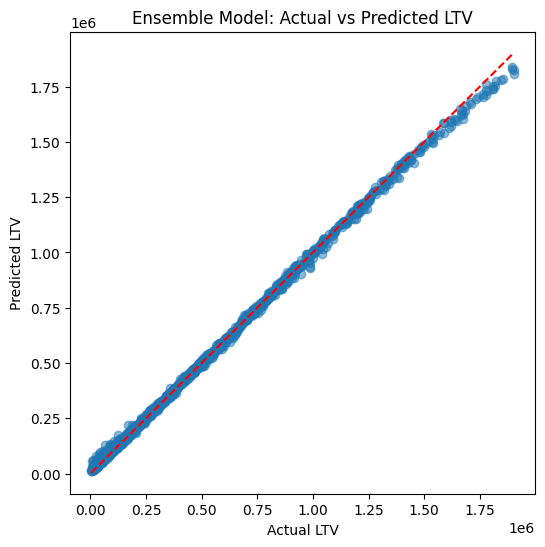

In [18]:
# === Step 9: Ensemble predictions by averaging ===
ensemble_preds = (rf_preds + xgb_preds) / 2

# === Step 10: Evaluate ensemble ===
mae = mean_absolute_error(y_test, ensemble_preds)
mse = mean_squared_error(y_test, ensemble_preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, ensemble_preds)

# Output the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# === Step 11: Visualization ===
plt.figure(figsize=(6,6))
plt.scatter(y_test, ensemble_preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual LTV')
plt.ylabel('Predicted LTV')
plt.title('Ensemble Model: Actual vs Predicted LTV')
plt.show()